### *Predicting Review Sentiment from IMDb movie reviews dataset, using Active Learning.*

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]
import keras
from keras import ops
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string
import numpy as np 
import seaborn as sns
tfds.disable_progress_bar()
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer

# Download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anjali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading data

In [ ]:
dataset = tfds.load(
    "imdb_reviews",
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False,
)
reviews, labels = tfds.as_numpy(dataset)

print("Total examples:", reviews.shape[0])

Total examples: 50000


## Visualisation

C:\Users\Anjali\AppData\Local\Temp\ipykernel_12156\3398107789.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Negative", "Positive"], y=counts, palette="coolwarm")


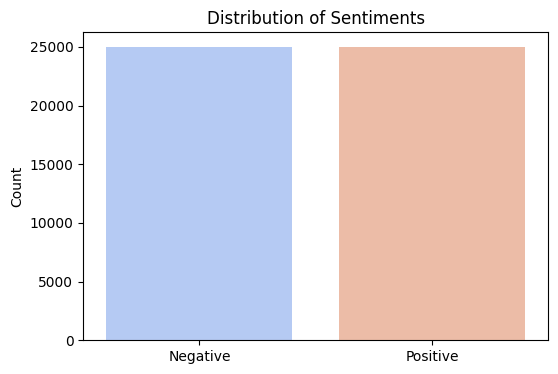

In [17]:
# Count the number of positive (1) and negative (0) reviews
unique, counts = np.unique(labels, return_counts=True)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=["Negative", "Positive"], y=counts, palette="coolwarm")
plt.title("Distribution of Sentiments")
plt.ylabel("Count")
plt.show()

In [23]:
# Load stopwords
stop_words = set(stopwords.words("english"))
tokenizer = TreebankWordTokenizer()

# Decode byte reviews into strings
decoded_reviews = [review.decode("utf-8") for review in reviews]

# Function to remove stopwords from a single review
def remove_stopwords(text):
    words = tokenizer.tokenize(text.lower())  # Tokenize without punkt
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    return " ".join(filtered_words)

# Apply function to all reviews
filtered_reviews = np.array([remove_stopwords(review) for review in decoded_reviews])

# # Print a few cleaned reviews
# print("Original:", decoded_reviews[0])  # First review before processing
# print("Filtered:", filtered_reviews[0])  # First review after processing


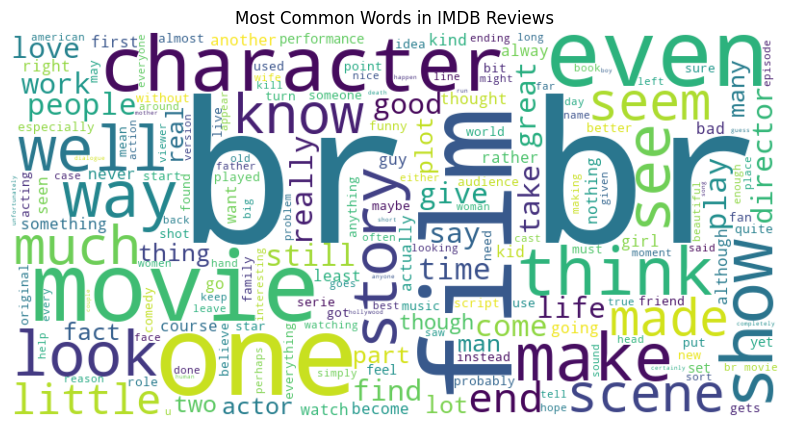

In [24]:
# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(filtered_reviews))

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in IMDB Reviews")
plt.show()


In [8]:
# # Filter positive and negative reviews
# positive_reviews = np.array(decoded_reviews)[labels == 1]
# negative_reviews = np.array(decoded_reviews)[labels == 0]

# # # Print some samples
# # print("Sample Positive Review:", positive_reviews[0])
# # print("Sample Negative Review:", negative_reviews[0])


In [7]:
# positive_reviews

In [8]:
# # Generate WordCloud
# wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(positive_reviews))

# # Plot
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.title("Most Common Words in IMDB Reviews")
# plt.show()

In [9]:
# wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(negative_reviews))

# # Plot
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.title("Most Common Words in IMDB Reviews")
# plt.show()

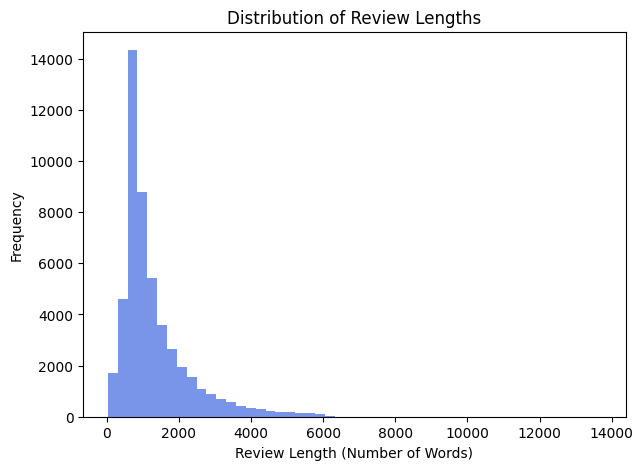

In [26]:
review_lengths = [len(review) for review in reviews]

plt.figure(figsize=(7,5))
plt.hist(review_lengths, bins=50, color='royalblue', alpha=0.7)
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()


In [11]:
# from collections import Counter

# # Convert all reviews to a single text
# positive_words = " ".join(positive_reviews).split()
# negative_words = " ".join(negative_reviews).split()

# # Count most common words
# pos_counts = Counter(positive_words).most_common(20)
# neg_counts = Counter(negative_words).most_common(20)

# # Convert to dictionary for visualization
# pos_words, pos_freqs = zip(*pos_counts)
# neg_words, neg_freqs = zip(*neg_counts)

# # Plot side-by-side
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# sns.barplot(y=list(pos_words), x=list(pos_freqs), ax=axs[0], color="green")
# axs[0].set_title("Top Words in Positive Reviews")

# sns.barplot(y=list(neg_words), x=list(neg_freqs), ax=axs[1], color="red")
# axs[1].set_title("Top Words in Negative Reviews")

# plt.show()


In [12]:
dataset

(<tf.Tensor: shape=(50000,), dtype=string, numpy=
 array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
        b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I

In [13]:
labels

array([0, 0, 0, ..., 0, 1, 1])

## Splitting

In [7]:
val_split = 2500
test_split = 2500
train_split = 7500

# Separating the negative and positive samples for manual stratification
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# Creating training, validation and testing splits
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0),
)
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)
pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positives, y_pool_positives)
)

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")

Initial training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 12500
Unlabeled positive pool: 12500


## Preprocessing

In [9]:
vectorizer = layers.TextVectorization(
    3000, standardize="lower_and_strip_punctuation", 
    output_sequence_length=150 
)
# Adapting the dataset
vectorizer.adapt(
    train_dataset.map(lambda x, y: x, 
                      num_parallel_calls=tf.data.AUTOTUNE).batch(256)
)


def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label


train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
vectorize_text('I LoVe This movie!!! It’s Amazing 😍🔥', 1) # Implicitly converts to a batch of 256

(<tf.Tensor: shape=(150,), dtype=int64, numpy=
 array([ 10, 111,  11,  18,   1, 510,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0])>,
 1)

## Modelling

In [ ]:
def create_model():
    model = keras.models.Sequential(
        [
            layers.Input(shape=(150,)),
            layers.Embedding(input_dim=3000, output_dim=128),                       # maps tokenized inp to the word and then into a 128 dim
            layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
            layers.GlobalMaxPool1D(),
            layers.Dense(20, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.summary()
    return model

In [ ]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

### Passive Learning

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 150, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,537 (1.63 MB)

 Trainable params: 426,537 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.6142 - false_negatives: 2543.8853 - false_positives: 5327.8154 - loss: 0.6708
Epoch 1: val_loss improved from inf to 0.68912, saving model to FullModelCheckpoint.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - binary_accuracy: 0.6141 - false_negatives: 2578.3923 - false_positives: 5344.3799 - loss: 0.6708 - val_binary_accuracy: 0.5134 - val_false_negatives: 2418.0000 - val_false_positives: 15.0000 - val_loss: 0.6891
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.6704 - false_negatives: 2610.8599 - false_positives: 3704.4395 - loss: 0.6170
Epoch 2: val_loss improved from 0.68912 to 0.48515, saving model to FullModelCheckpoint.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - binary_accuracy: 0.6707 - false_negatives: 2627.7659 - false_positives: 3721.9810 - loss: 0.6167 - val_binary_accuracy: 0.7862 - val_false_negatives: 342.0000 - val_false_positives: 727.0000 - val_loss: 0.4851
Epoch 3/

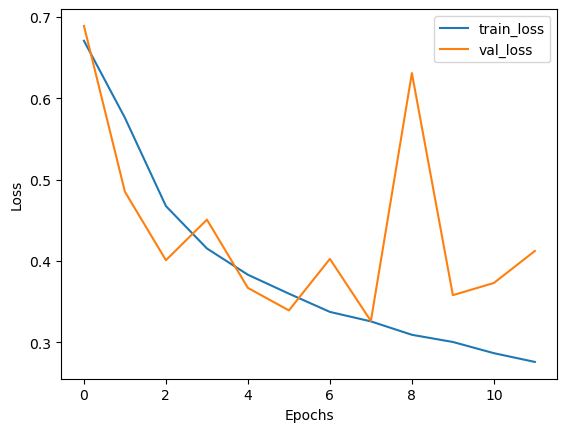

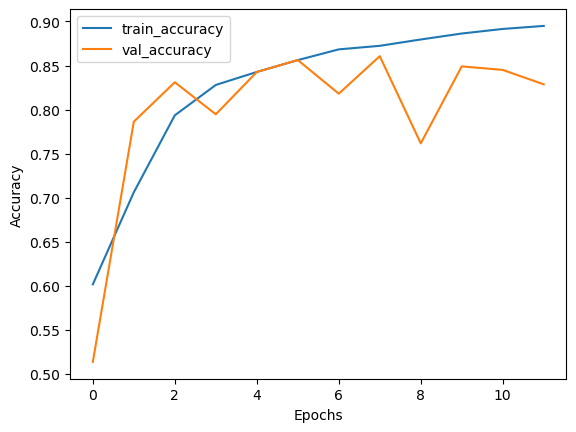

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'binary_accuracy': 0.8579999804496765, 'false_negatives': 328.0, 'false_positives': 382.0, 'loss': 0.33115121722221375}
----------------------------------------------------------------------------------------------------


In [9]:
def train_full_model(full_train_dataset, val_dataset, test_dataset):
    
    model = create_model()
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # We will save the best model at every epoch and load the best one for evaluation on the test set
    history = model.fit(
        full_train_dataset.batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=4, verbose=1),
            keras.callbacks.ModelCheckpoint(
                "FullModelCheckpoint.keras", verbose=1, save_best_only=True
            ),
        ],
    )

    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    model = keras.models.load_model("FullModelCheckpoint.keras")

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)
    return model


# Sampling the full train dataset to train on
full_train_dataset = (
    train_dataset.concatenate(pool_positives)
    .concatenate(pool_negatives)
    .cache()
    .shuffle(20000)
)

# Training the full model
full_dataset_model = train_full_model(full_train_dataset, val_dataset, test_dataset)

### Active Learning

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 128)       │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 150, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,537 (1.63 MB)

 Trainable params: 426,537 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Starting to train with 15000 samples
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - binary_accuracy: 0.5063 - false_negatives_1: 1834.1187 - false_positives_1: 1909.7797 - loss: 0.6927
Epoch 1: val_loss improved from inf to 0.68752, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - binary_accuracy: 0.5066 - false_negatives_1: 1862.2167 - false_positives_1: 1938.1333 - loss: 0.6927 - val_binary_accuracy: 0.6366 - val_false_negatives_1: 1340.0000 - val_false_positives_1: 477.0000 - val_loss: 0.6875
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.5983 - false_negatives_1: 1518.6271 - false_positives_1: 1515.8306 - loss: 0.6791
Epoch 2: val_loss improved from 0.68752 to 0.63438, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - binary_accuracy: 0.5986 - false_negatives_1: 1540.6500 - false_positives_1: 1539.4166 - loss: 0.6790 - val_binary_accuracy: 0.6482 - val_false_negatives_1: 1573.0000 - val_false_positives_1: 186.0000 - val_loss: 0.6344
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.6627 - false_negatives_1: 1143.0677 - false_positives_1: 1385.7627 - loss: 0.6241
Epoch 3: val_loss improved from 0.63438 to 0.54261, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - binary_accuracy: 0.6630 - false_negatives_1: 1158.5167 - false_positives_1: 1407.8833 - loss: 0.6239 - val_binary_accuracy: 0.7606 - val_false_negatives_1: 561.0000 - val_false_positives_1: 636.0000 - val_loss: 0.5426
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.7327 - false_negatives_1: 861.0678 - false_positives_1: 1175.5763 - loss: 0.5557
Epoch 4: val_loss improved from 0.54261 to 0.46448, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - binary_accuracy: 0.7328 - false_negatives_1: 873.4333 - false_positives_1: 1194.1500 - loss: 0.5555 - val_binary_accuracy: 0.7998 - val_false_negatives_1: 484.0000 - val_false_positives_1: 517.0000 - val_loss: 0.4645
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.7652 - false_negatives_1: 675.1017 - false_positives_1: 1126.7627 - loss: 0.5124
Epoch 5: val_loss did not improve from 0.46448
59/59 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - binary_accuracy: 0.7653 - false_negatives_1: 685.7833 - false_positives_1: 1143.1167 - loss: 0.5121 - val_binary_accuracy: 0.7366 - val_false_negatives_1: 96.0000 - val_false_positives_1: 1221.0000 - val_loss: 0.5123
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - binary_accuracy: 0.7852 - false_negatives_1: 648.8813 - false_positives_1: 985.5763 - loss: 0.4641 
Epoch 6: val_loss improved from 0.46448 to 0.40750, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 928s 16s/step - binary_accuracy: 0.7853 - false_negatives_1: 659.0000 - false_positives_1: 999.9000 - loss: 0.4640 - val_binary_accuracy: 0.8150 - val_false_negatives_1: 266.0000 - val_false_positives_1: 659.0000 - val_loss: 0.4075
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8161 - false_negatives_1: 566.4237 - false_positives_1: 823.0000 - loss: 0.4298
Epoch 7: val_loss improved from 0.40750 to 0.39377, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - binary_accuracy: 0.8162 - false_negatives_1: 575.7833 - false_positives_1: 835.9500 - loss: 0.4299 - val_binary_accuracy: 0.8336 - val_false_negatives_1: 402.0000 - val_false_positives_1: 430.0000 - val_loss: 0.3938
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8294 - false_negatives_1: 558.1865 - false_positives_1: 755.3560 - loss: 0.4013
Epoch 8: val_loss improved from 0.39377 to 0.38424, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - binary_accuracy: 0.8294 - false_negatives_1: 567.0667 - false_positives_1: 767.9167 - loss: 0.4014 - val_binary_accuracy: 0.8364 - val_false_negatives_1: 377.0000 - val_false_positives_1: 441.0000 - val_loss: 0.3842
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8399 - false_negatives_1: 528.2203 - false_positives_1: 715.7797 - loss: 0.3872
Epoch 9: val_loss improved from 0.38424 to 0.37006, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - binary_accuracy: 0.8399 - false_negatives_1: 536.4333 - false_positives_1: 727.1334 - loss: 0.3872 - val_binary_accuracy: 0.8390 - val_false_negatives_1: 388.0000 - val_false_positives_1: 417.0000 - val_loss: 0.3701
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8413 - false_negatives_1: 510.6441 - false_positives_1: 693.9153 - loss: 0.3806
Epoch 10: val_loss did not improve from 0.37006
59/59 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - binary_accuracy: 0.8415 - false_negatives_1: 518.1000 - false_positives_1: 704.1667 - loss: 0.3805 - val_binary_accuracy: 0.7994 - val_false_negatives_1: 133.0000 - val_false_positives_1: 870.0000 - val_loss: 0.4374
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8530 - false_negatives_1: 473.6102 - false_positives_1: 648.0000 - loss: 0.3595
Epoch 11: val_loss improved from 0.37006 to 0.36780, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - binary_accuracy: 0.8530 - false_negatives_1: 480.8500 - false_positives_1: 657.6667 - loss: 0.3594 - val_binary_accuracy: 0.8414 - val_false_negatives_1: 286.0000 - val_false_positives_1: 507.0000 - val_loss: 0.3678
Epoch 12/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8789 - false_negatives_1: 419.0000 - false_positives_1: 536.1695 - loss: 0.3214
Epoch 12: val_loss did not improve from 0.36780
59/59 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - binary_accuracy: 0.8788 - false_negatives_1: 426.0333 - false_positives_1: 545.1667 - loss: 0.3216 - val_binary_accuracy: 0.8068 - val_false_negatives_1: 141.0000 - val_false_positives_1: 825.0000 - val_loss: 0.4226
Epoch 13/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.8794 - false_negatives_1: 393.4407 - false_positives_1: 523.7966 - loss: 0.3099
Epoch 13: val_loss improved from 0.36780 to 0.36730, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - binary_accuracy: 0.8794 - false_negatives_1: 400.1167 - false_positives_1: 532.1833 - loss: 0.3100 - val_binary_accuracy: 0.8396 - val_false_negatives_1: 265.0000 - val_false_positives_1: 537.0000 - val_loss: 0.3673
Epoch 14/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8873 - false_negatives_1: 387.0508 - false_positives_1: 504.2034 - loss: 0.2943
Epoch 14: val_loss did not improve from 0.36730
59/59 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - binary_accuracy: 0.8872 - false_negatives_1: 393.6167 - false_positives_1: 512.2500 - loss: 0.2944 - val_binary_accuracy: 0.8002 - val_false_negatives_1: 138.0000 - val_false_positives_1: 861.0000 - val_loss: 0.4498
Epoch 15/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8899 - false_negatives_1: 367.0847 - false_positives_1: 472.0508 - loss: 0.2866
Epoch 15: val_loss did not improve from 0.36730
59/59 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - binary_accuracy: 0.8899 - false_negatives_1: 

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 583ms/step
----------------------------------------------------------------------------------------------------
Number of zeros incorrectly classified: 304.0, Number of ones incorrectly classified: 506.0
Sample ratio for positives: 0.6246913580246913, Sample ratio for negatives:0.37530864197530867
Starting training with 24998 samples
----------------------------------------------------------------------------------------------------
Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8510 - false_negatives_3: 819.9796 - false_positives_3: 1002.6633 - loss: 0.3772
Epoch 1: val_loss did not improve from 0.36730
98/98 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - binary_accuracy: 0.8511 - false_negatives_3: 827.7980 - false_positives_3: 1012.0909 - loss: 0.3770 - val_binary_accuracy: 0.8282 - val_false_negatives_3: 625.0000 - val_false_positives_3: 234.0000 - val_loss: 0.3845
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8723 

98/98 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - binary_accuracy: 0.8723 - false_negatives_3: 729.1010 - false_positives_3: 907.6061 - loss: 0.3212 - val_binary_accuracy: 0.8508 - val_false_negatives_3: 403.0000 - val_false_positives_3: 343.0000 - val_loss: 0.3502
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8812 - false_negatives_3: 674.2245 - false_positives_3: 841.8163 - loss: 0.3005
Epoch 3: val_loss did not improve from 0.35023
98/98 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - binary_accuracy: 0.8812 - false_negatives_3: 680.6263 - false_positives_3: 850.1010 - loss: 0.3005 - val_binary_accuracy: 0.8444 - val_false_negatives_3: 491.0000 - val_false_positives_3: 287.0000 - val_loss: 0.3623
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8901 - false_negatives_3: 647.5102 - false_positives_3: 759.5000 - loss: 0.2860
Epoch 4: val_loss did not improve from 0.35023
98/98 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - binary_accuracy: 0.8901 - false_negatives_3: 653

20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step 
----------------------------------------------------------------------------------------------------
Number of zeros incorrectly classified: 443.0, Number of ones incorrectly classified: 338.0
Sample ratio for positives: 0.4327784891165173, Sample ratio for negatives:0.5672215108834827
Starting training with 29997 samples
----------------------------------------------------------------------------------------------------
Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8651 - false_negatives_4: 941.4407 - false_positives_4: 1061.1187 - loss: 0.3290
Epoch 1: val_loss did not improve from 0.35023
118/118 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - binary_accuracy: 0.8651 - false_negatives_4: 948.7311 - false_positives_4: 1069.8992 - loss: 0.3290 - val_binary_accuracy: 0.8522 - val_false_negatives_4: 281.0000 - val_false_positives_4: 458.0000 - val_loss: 0.3524
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - binary_accuracy: 0

118/118 ━━━━━━━━━━━━━━━━━━━━ 81s 688ms/step - binary_accuracy: 0.8839 - false_negatives_4: 830.6891 - false_positives_4: 955.6050 - loss: 0.2934 - val_binary_accuracy: 0.8522 - val_false_negatives_4: 368.0000 - val_false_positives_4: 371.0000 - val_loss: 0.3380
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.8901 - false_negatives_4: 774.7797 - false_positives_4: 915.0255 - loss: 0.2860
Epoch 3: val_loss did not improve from 0.33798
118/118 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - binary_accuracy: 0.8901 - false_negatives_4: 781.1177 - false_positives_4: 922.6891 - loss: 0.2861 - val_binary_accuracy: 0.8504 - val_false_negatives_4: 419.0000 - val_false_positives_4: 329.0000 - val_loss: 0.3496
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - binary_accuracy: 0.8994 - false_negatives_4: 729.7542 - false_positives_4: 844.7627 - loss: 0.2631
Epoch 4: val_loss did not improve from 0.33798
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 641ms/step - binary_accuracy: 0.8994 - false

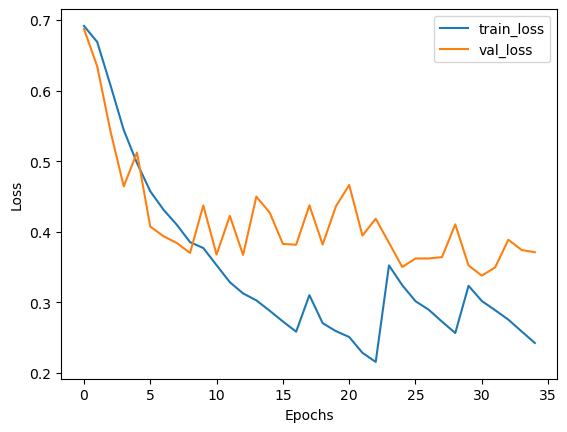

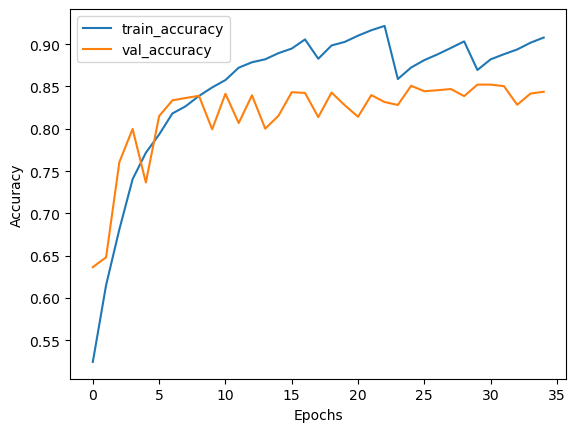

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'binary_accuracy': 0.8500000238418579, 'false_negatives_4': 378.0, 'false_positives_4': 372.0, 'loss': 0.3480008840560913}
----------------------------------------------------------------------------------------------------


In [10]:
def train_active_learning_models(
    train_dataset,
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    num_iterations=3,
    sampling_size=5000,
):

    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = create_model()
    # We will monitor the false positives and false negatives predicted by our model
    # These will decide the subsequent sampling ratio for every Active Learning loop
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = keras.callbacks.ModelCheckpoint(
        "AL_Model.keras", save_best_only=True, verbose=1 # changed to .keras
    )
    # Here, patience is set to 4. This can be set higher if desired.
    early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)

    print(f"Starting to train with {len(train_dataset)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_dataset.cache().shuffle(20000).batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    for iteration in range(num_iterations):
        # Getting predictions from previously trained model
        predictions = model.predict(test_dataset)

        # Generating labels from the output probabilities
        rounded = ops.where(ops.greater(predictions, 0.5), 1, 0)

        # Evaluating the number of zeros and ones incorrrectly classified
        _, _, false_negatives, false_positives = model.evaluate(test_dataset, verbose=0)

        print("-" * 100)
        print(
            f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
        )

        # This technique of Active Learning demonstrates ratio based sampling where
        # Number of ones/zeros to sample = Number of ones/zeros incorrectly classified / Total incorrectly classified
        if false_negatives != 0 and false_positives != 0:
            total = false_negatives + false_positives
            sample_ratio_ones, sample_ratio_zeros = (
                false_positives / total,
                false_negatives / total,
            )
        # In the case where all samples are correctly predicted, we can sample both classes equally
        else:
            sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5

        print(
            f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
        )

        # Sample the required number of ones and zeros
        sampled_dataset = pool_negatives.take(
            int(sample_ratio_zeros * sampling_size)
        ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

        # Skip the sampled data points to avoid repetition of sample
        pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
        pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

        # Concatenating the train_dataset with the sampled_dataset
        train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(
            tf.data.AUTOTUNE
        )

        print(f"Starting training with {len(train_dataset)} samples")
        print("-" * 100)

        # We recompile the model to reset the optimizer states and retrain the model
        model.compile(
            loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.FalseNegatives(),
                keras.metrics.FalsePositives(),
            ],
        )
        history = model.fit(
            train_dataset.cache().shuffle(20000).batch(256),
            validation_data=val_dataset,
            epochs=20,
            callbacks=[
                checkpoint,
                keras.callbacks.EarlyStopping(patience=4, verbose=1),
            ],
        )

        # Appending the history
        losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
        model = keras.models.load_model("AL_Model.keras") # changed to .keras

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model


active_learning_model = train_active_learning_models(
    train_dataset, pool_negatives, pool_positives, val_dataset, test_dataset
)

In [10]:
# Load the trained model
model = keras.models.load_model("FullModelCheckpoint.h5")

# Example input (should be preprocessed like training data)
new_texts = ["This movie was fantastic!", "I did not enjoy the plot."]

# Convert text to vectorized format (assuming `vectorizer` is available)
vectorized_texts = vectorizer(new_texts)

# Run inference
predictions = model.predict(vectorized_texts)

# Convert probabilities to class labels
predicted_labels = ["Positive" if p > 0.5 else "Negative" for p in predictions]

# Print results
for text, label in zip(new_texts, predicted_labels):
    print(f"Review: {text} --> Sentiment: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
Review: This movie was fantastic! --> Sentiment: Positive
Review: I did not enjoy the plot. --> Sentiment: Negative
